<a href="https://colab.research.google.com/github/adel-abh/Generatin-random-recipies-using-LSTM/blob/main/Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout
from keras.metrics import Precision, Recall
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import re
import matplotlib.pyplot as plt
import time
import itertools
import plotly.express as px
import seaborn as sns
import statistics

In [ ]:
data2=pd.read_csv('flavor_db.csv')
df= pd.read_csv("Data_food_final.csv")
food = df

In [ ]:
def extract_list_of_ingredients(ingredient_string):
    ingredient_string = ingredient_string.strip("][ '").split(",")
    ingredient_list = list()
    for ingredient in ingredient_string:
        ingredient_list.append(ingredient.strip("' ' "))

    return ingredient_list

In [ ]:
food['ingredients_list'] = food.apply(lambda x: extract_list_of_ingredients(x['Ingredients_string']), axis=1)

In [ ]:
recipes_list = list()
for index, row in food.iterrows():
    ingredients_string = ", ".join(row['ingredients_list']) # Convert list to string
    recipes_list.append(extract_list_of_ingredients(ingredients_string))


In [ ]:
unique_ingredient_list = list()

for index, recipe in enumerate(recipes_list):
    for ingredient in recipe:
        if ingredient not in unique_ingredient_list:
            unique_ingredient_list.append(ingredient)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(recipes_list)
vocab_size = len(tokenizer.word_index) + 1


In [ ]:
# Train a Word2Vec model on the sentences
w2v_model = Word2Vec(recipes_list, vector_size=100, window=5, min_count=1, workers=4)


In [ ]:
# Create an embedding matrix
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]


In [ ]:
# Create input-output pairs
input_sequences = []
output_tokens = []
for sentence in recipes_list:
    token_list = tokenizer.texts_to_sequences([sentence])[0]
    for i in range(1, len(token_list)):
        input_sequence = token_list[:i]
        output_token = token_list[i]
        input_sequences.append(input_sequence)
        output_tokens.append(output_token)

# Pad sequences and obtain variables
avg_sequence_len = int(np.mean([len(x) for x in recipes_list]))
input_sequences = np.array(pad_sequences(input_sequences, maxlen=avg_sequence_len, padding='pre'))
X = input_sequences
y = to_categorical(output_tokens, num_classes=vocab_size)


In [ ]:
# Define the LSTM model
model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=None, trainable=False))
model.add(LSTM(256, return_sequences=True))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(vocab_size, activation='softmax'))


In [ ]:
# Compile and train the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])
model.fit(X, y, epochs=150)

In [ ]:
def generate_ingredient(ingredient1, ingredient2, ingredient3):
    # Generate a sequence of input tokens
    input_text = ' '.join([str(ingredient) for ingredient in [ingredient1, ingredient2, ingredient3]])
    input_tokens = input_text.split()

    # Convert the input tokens to their corresponding integer indexes
    input_seq = []
    for token in input_tokens:
        if token in tokenizer.word_index:
            input_seq.append(tokenizer.word_index[token])
        else:
            input_seq.append(0)

    # Pad the input sequence to the average sequence length
    avg_sequence_len = int(np.mean([len(x) for x in recipes_list]))
    padded_input_seq = pad_sequences([input_seq], maxlen=avg_sequence_len, padding='pre')

    # Use the LSTM model to make a prediction
    prediction = model.predict(padded_input_seq)

    # Convert the prediction to a token index
    token_index = np.argmax(prediction)

    # Convert the token index to a word
    word = tokenizer.index_word[token_index]

    # return the ingredient
    return(word)


In [ ]:
def generate_recipe(recipe):
    # Generate 8 new ingredients for the recipe
    recipe_list = [i.strip() for i in recipe]
    new_ingredients = []
    for i in range(8):
      new_ingredient = generate_ingredient(recipe_list[-3],recipe_list[-2], recipe_list[-1])
      new_ingredients.append(new_ingredient)
      recipe_list.append(new_ingredient)

    return recipe_list


In [ ]:
def lookup_set(ingredient,data):
    """Arguments:
        ingridient: String representing the ingrediant alias
        data : Dataframe representing the molecular dataset
    returns
        set of molecules of that ingredient"""
    return eval(data.query(f"alias.str.fullmatch('{ingredient}')")['molecules'].tolist()[0])

def avg_flavor(recipe):
    '''calculates the average flavor sharing of one recipe
    Arguments
        recipe : dictionary which represents a recipe
    Returns
        score :a float representing average flavor sharing'''
    somme=0
    nR=len(recipe.keys())
    combs=list(itertools.combinations(recipe.keys(), 2))
    for element in combs:
        somme=somme+(len(recipe[element[0]].intersection(recipe[element[1]])))
    score=somme*2/(nR*(nR-1))
    return score


In [ ]:
import json
avg_values = []
df = pd.DataFrame()
ingredient_counts_list = []
for i in range(0, 100):
    recipes = []
    ingredient_counts = Counter()

    for j in range(0, 348):
        recipe = random.sample(list_ingredients, 6)
        recipe_str = json.dumps(recipe)
        recipe_list = [ingredient.strip() for ingredient in json.loads(recipe_str)]
        recipes.append(generate_recipe(recipe_list))

    df['recipes']=recipes
    df['Ingredients_string'] = df.recipes.apply(lambda x:dict.fromkeys(x, " "))
    df['Ingredients_dict'] = df['Ingredients_string'].apply(lambda ingredients: dict.fromkeys(ingredients, set()))
    for element in df['Ingredients_dict']:
        for k,v in element.items():
            element[k]=lookup_set(k,data2)
    df['avg_flavor']=df['Ingredients_dict'].apply(lambda x:avg_flavor(x))
    final_score=sum(df['avg_flavor'])/df['avg_flavor'].shape[0]
    avg_values.append(34.275600390776006-final_score)




In [ ]:
# count negative values
count=0
for i in avg_values:
    if i <0:
        count=count+1
print(count)

100


In [ ]:
# count negative values
count1=0
for i in avg_values:
    if i >=0:
        count1=count1+1
print(count1)

0


[Text(0.5, 1.0, 'recipe size = 11')]

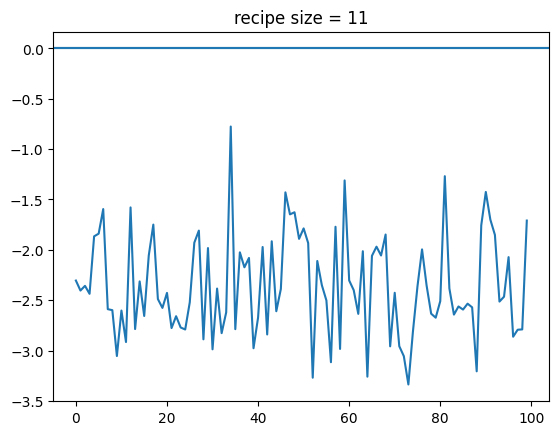

In [ ]:
x = [i for i in range(len(avg_values))]
graph = sns.lineplot(x=x, y=avg_values)
graph.axhline(0)
graph.axhline(0)
graph.set(title='recipe size = 11')


In [ ]:
min_value,max_value,mean=min(avg_values),max(avg_values),statistics.mean(avg_values)
print(f'the min is {min_value}')
print(f'the max is {max_value}')
print(f'the mean is {mean}')

the min is -3.3373988545507918
the max is -0.7752907040805965
the mean is -2.354298288131271


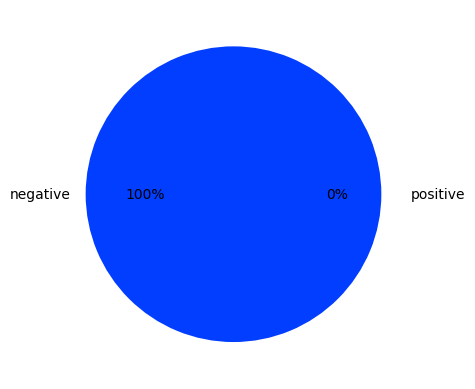

In [ ]:

data = [count,count1]
keys = ['negative','positive']

# declaring exploding pie
explode = [0, 0.1]
# define Seaborn color palette to use
palette_color = sns.color_palette('bright')

# plotting data on chart
plt.pie(data, labels=keys, colors=palette_color,
		explode=explode, autopct='%.0f%%')

# displaying chart
plt.show()
